![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# **Taller No. 10 - ISIS4825**

## **Support Vector Machines, Modelo Conjuntos y Extracción de Características**
## **Contenido**
1. [**Objetivos**](#id1)
2. [**Problema**](#id2)
3. [**Importando las librerías necesarias para el laboratorio**](#id3)
4. [**Visualización y Análisis Exploratorio**](#id4)
5. [**Preparación de los Datos**](#id5)
6. [**Modelamiento**](#id6)
7. [**Predicción**](#id7)
8. [**Validación**](#id8)
9. [**Trabajo Asíncrono**](#id9)

## **Objetivos**<a name="id1"></a>
- Familiarizarse con las máquinas de soporte vectorial y los modelos conjuntos.
- Hacer un recorrido básico por las imágenes médicas.
- Extraer características básicas de imágenes.

## **Problema**<a name="id2"></a>
- En un dataset de imágenes médicas, buscamos clasificar todas clasificar todas aquellas imágenes que sean resonancias magnéticas de seno y tomografías de diafragma.

## **Notebook Configuration**

In [ ]:
!shred -u setup_colab.py
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_workshop_10()

## **Importando las librerías necesarias para el laboratorio**<a name="id3"></a>

In [139]:
from utils import general as gen

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             confusion_matrix, f1_score)
from sklearn.utils import resample

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
import seaborn as sns

from skimage import io

from tqdm.auto import tqdm

In [176]:
def cat_frequencies(labels):
    freq_p = labels.mean()
    freq_n = 1 - freq_p
    return freq_p, freq_n

### **Carga de Datos**

In [7]:
data_dir = "./data"

In [72]:
abdomen_dir = gen.create_and_verify(data_dir, "AbdomenCT")
breast_dir = gen.create_and_verify(data_dir, "BreastMRI")

abdomen_list = gen.read_listdir(abdomen_dir)
breast_list = gen.read_listdir(breast_dir)

abdomen_size = len(abdomen_list)
breast_size = len(breast_list)

In [177]:
total_data = np.zeros((breast_size + abdomen_size, 64, 64), dtype="uint8")
total_targets = np.zeros((breast_size + abdomen_size), dtype="uint8")

In [178]:
total_targets[:abdomen_size] = 1
total_targets[abdomen_size:] = 0

In [179]:
idx = 0
for dir_ in tqdm(gen.read_listdir(abdomen_dir)):
    total_data[idx] = io.imread(dir_)
    idx += 1

for dir_ in tqdm(gen.read_listdir(breast_dir)):
    total_data[idx] = io.imread(dir_)
    idx += 1

In [180]:
total_data = total_data.reshape(-1, 4096)

In [181]:
total = np.concatenate([total_data, total_targets.reshape(-1, 1)], axis=1)

In [182]:
neg_class = total[total_targets == 0]
pos_class = total[total_targets == 1]

In [183]:
neg_class_downsampled = resample(neg_class, replace=False, 
                                 n_samples=200, random_state=1234)

In [184]:
unbalanced_data = np.concatenate([pos_class, neg_class_downsampled])

In [185]:
total_data = unbalanced_data[:, :-1]
total_targets = unbalanced_data[:, -1]

In [186]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1234)

In [187]:
for train_index, test_index in sss.split(total_data, total_targets):
    full_X_train, X_test = total_data[train_index], total_data[test_index]
    full_y_train, y_test = total_targets[train_index], total_targets[test_index]

In [188]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=5678)

In [189]:
for train_index, val_index in sss.split(full_X_train, full_y_train):
    X_train, X_val = full_X_train[train_index], full_X_train[val_index]
    y_train, y_val = full_y_train[train_index], full_y_train[val_index]

In [190]:
svm_clf = SVC()

In [191]:
%%time
svm_clf.fit(X_train, y_train)

CPU times: user 11.6 s, sys: 7.19 ms, total: 11.6 s
Wall time: 11.6 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [192]:
%%time
y_pred = svm_clf.predict(X_test)

CPU times: user 3.29 s, sys: 398 µs, total: 3.29 s
Wall time: 3.3 s


In [193]:
conf_matrix = confusion_matrix(y_test, y_pred)

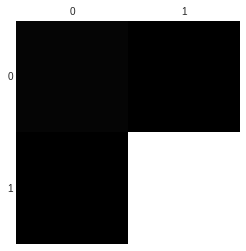

In [194]:
plt.matshow(conf_matrix, cmap="gray")
plt.show()

In [195]:
accuracy_score(y_test, y_pred)

1.0

In [199]:
log_clf = LogisticRegression(n_jobs=-1)

In [200]:
%%time
log_clf.fit(X_train, y_train)

CPU times: user 117 ms, sys: 142 ms, total: 260 ms
Wall time: 28.2 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)